# Transformer Model
In this notebook, we show an example of how Transformer can be used with darts.
If you are new to darts, we recommend you first follow the `darts-intro.ipynb` notebook.

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.preprocessing import ScalerWrapper
from darts.models import TransformerModel, ExponentialSmoothing
from darts.backtesting import backtest_forecasting
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

Importing plotly failed. Interactive plots will not work.


### Some hyper-parameters:

In [4]:
N_EPOCHS = 1000
NR_EPOCHS_VALIDATION_PERIOD = 10

In [5]:
# Number of previous time stamps taken into account.
SEQ_LENGTH = 10
# number of output time-steps to predict
OUTPUT_LEN = 1
# Number of layers in encoder/decoder
NUM_LAYERS = 6

## Air Passenger Example

In [6]:
# Read data:
df = pd.read_csv('AirPassengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', ['#Passengers'])

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp('19590101'))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
# Change name
scaler = ScalerWrapper()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)

We train a standard transformer architecture with default hyperparameters, tweaking only two of them:

* _d\_model_, the input dimensionality of the transformer architecture (*after* performing time series embedding). Its default value is 512. We lower the value from 512 to 64, since it is hard to learn such an high-dimensional representation from an univariate time series
* _nhead_, the number of heads in the multi-head attention mechanism. We increase the value from 8 to 32. This means that we compute multi-head attention with 32 heads of size _d\_model_/_nhead_=64/32=2 each. This way, we obtain low-dimensional heads that are hopefully suitable to learn from univariate time series

In [7]:
my_model = TransformerModel(
    batch_size = 32,
    input_length = SEQ_LENGTH,
    input_size = 1,
    output_length = OUTPUT_LEN,
    output_size = 1,
    n_epochs = N_EPOCHS,
    model_name = 'air_transformer',
    log_tensorboard=True,
    nr_epochs_val_period = NR_EPOCHS_VALIDATION_PERIOD,
    model = None,
    d_model = 64,
    nhead = 32,
    num_encoder_layers = 6,
    num_decoder_layers = 6,
    dim_feedforward = 2048,
    dropout = 0.1,
    activation = "relu",
    custom_encoder = None,
    custom_decoder = None,
    random_state=42,
)

In [8]:
my_model.fit(train_scaled, val_scaled, verbose=True)

Training loss: 0.0108, validation loss: 0.0464


### Look at predictions on the validation set
Use the "current" model - i.e., the model at the end of the training procedure:

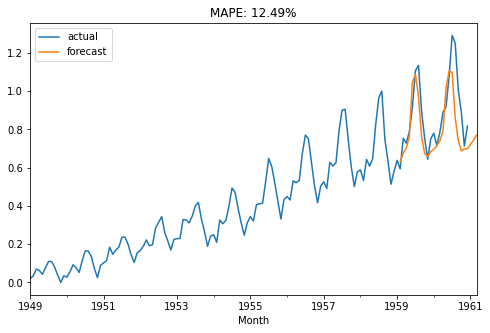

In [9]:
def eval_model(model):
    pred_series = model.predict(n=26)
    plt.figure(figsize=(8,5))
    series_scaled.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_scaled)))
    plt.legend();
    
eval_model(my_model)

Use the best model obtained over training, according to validation loss:

loading model_best_590.pth.tar


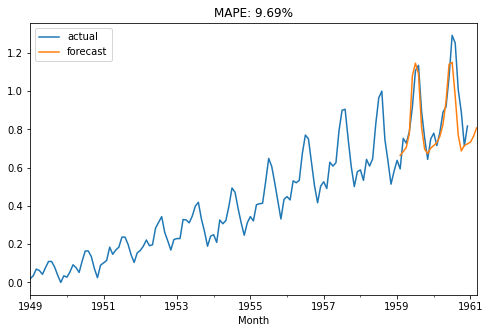

In [10]:
best_model = TransformerModel.load_from_checkpoint(model_name='air_transformer', best=True)
eval_model(best_model)

### Backtesting
Let's backtest our `RNN` model, with a forecast horizon of 6 months:

In [11]:
# Perform the actual backtest
backtest_series = backtest_forecasting(series_scaled,
                                       my_model,
                                       pd.Timestamp('19590101'), 
                                       fcast_horizon_n=6,
                                       use_full_output_length = False,
                                       retrain=False,
                                       verbose=True)

MAPE: 8.37%


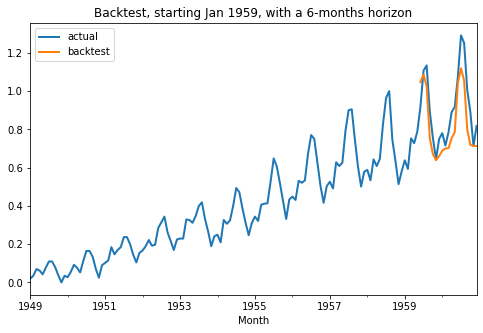

In [12]:
plt.figure(figsize=(8,5))
series_scaled.plot(label='actual', lw=2)
backtest_series.plot(label='backtest', lw=2)
plt.legend()
plt.title('Backtest, starting Jan 1959, with a 6-months horizon');
print('MAPE: {:.2f}%'.format(mape(scaler.inverse_transform(series_scaled), 
                                  scaler.inverse_transform(backtest_series))))

### Trials with a longer output length

In [13]:
my_model_long_out = TransformerModel(
    batch_size = 32,
    input_length = SEQ_LENGTH,
    input_size = 1,
    output_length = OUTPUT_LEN*4,
    output_size = 1,
    n_epochs = N_EPOCHS,
    model_name = 'air_transformer_long_out',
    log_tensorboard=True,
    nr_epochs_val_period = NR_EPOCHS_VALIDATION_PERIOD,
    model = None,
    d_model = 64,
    nhead = 32,
    num_encoder_layers = 6,
    num_decoder_layers = 6,
    dim_feedforward = 2048,
    dropout = 0.1,
    activation = "relu",
    custom_encoder = None,
    custom_decoder = None,
    random_state=42,
)

In [14]:
my_model_long_out.fit(train_scaled, val_series=val_scaled, verbose=True)

Training loss: 0.0091, validation loss: 0.0949


Result of training

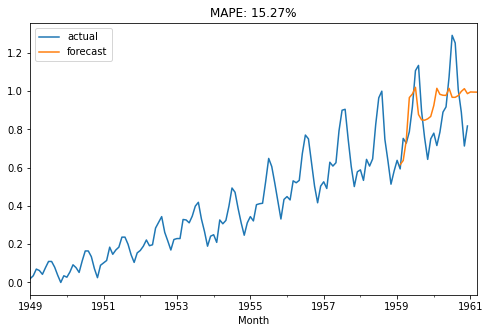

In [15]:
eval_model(my_model_long_out)

Evaluate best model

loading model_best_440.pth.tar


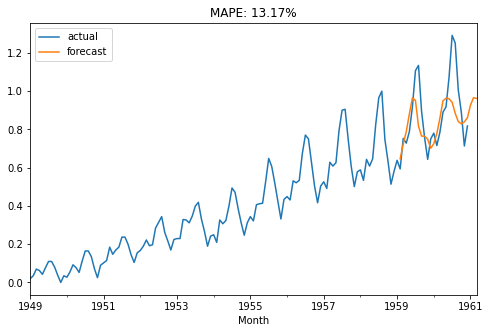

In [16]:
best_model_long_out = TransformerModel.load_from_checkpoint(model_name='air_transformer_long_out', best=True)
eval_model(best_model_long_out)

Backtest with 6 month forecasting horizon

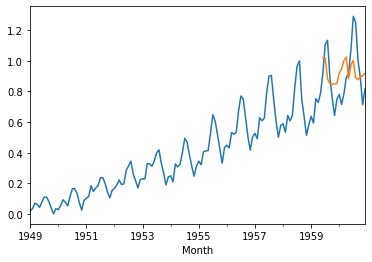

In [17]:
backtest_series = backtest_forecasting(series_scaled, my_model_long_out, pd.Timestamp('19590101'), 
                                       fcast_horizon_n=6, use_full_output_length = False, retrain=False, verbose=True)
series_scaled.plot()
backtest_series.plot()

## Monthly sunspots
Let's now try a more challenging time series; that of the monthly number of sunspots since 1749. First, we build the time series from the data, and check its periodicity.

(True, 125)

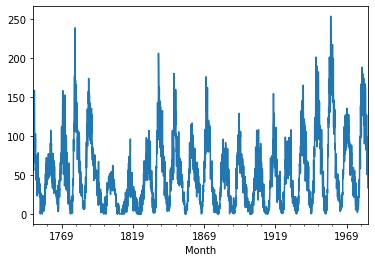

In [18]:
df2 = pd.read_csv('monthly-sunspots.csv', delimiter=",")
series_sunspot = TimeSeries.from_dataframe(df2, 'Month', ['Sunspots'])

series_sunspot.plot()
check_seasonality(series_sunspot, max_lag=240)

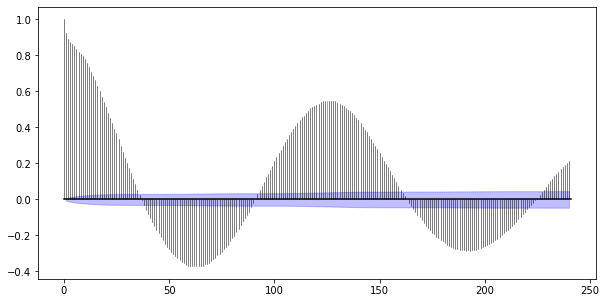

In [19]:
plot_acf(series_sunspot, 125, max_lag=240) # ~11 years seasonality

In [20]:
train_sp, val_sp = series_sunspot.split_after(pd.Timestamp('19401001'))

transformer_sunspot = ScalerWrapper()
train_sp_scaled = transformer_sunspot.fit_transform(train_sp)
val_sp_scaled = transformer_sunspot.transform(val_sp)
series_sp_scaled = transformer_sunspot.transform(series_sunspot)

In [21]:
SEQ_LENGTH = 135
OUTPUT_LEN = 1

In [22]:
my_model_sun = TransformerModel(
    batch_size = 32,
    input_length = SEQ_LENGTH,
    input_size = 1,
    output_length = OUTPUT_LEN,
    output_size = 1,
    n_epochs = 1,
    model_name = 'sun_transformer',
    log_tensorboard=True,
    nr_epochs_val_period = 1,
    model = None,
    d_model = 64,
    nhead = 32,
    num_encoder_layers = 6,
    num_decoder_layers = 6,
    dim_feedforward = 2048,
    dropout = 0.1,
    activation = "relu",
    custom_encoder = None,
    custom_decoder = None,
    random_state=42,
)

my_model_sun.fit(train_sp_scaled, val_series=val_sp_scaled, verbose=True)

Training loss: 0.3311, validation loss: 0.0754


In [23]:
def eval_model(model):
    pred_series = model.predict(n=100)
    plt.figure(figsize=(8,5))
    series_sp_scaled.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_sp_scaled)))
    plt.legend();

Evaluate best model

loading model_best_0.pth.tar


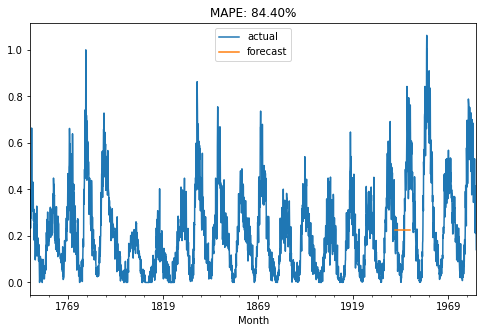

In [24]:
best_model_sun = TransformerModel.load_from_checkpoint(model_name='sun_transformer', best=True)
eval_model(best_model_sun)

To evaluate our model, we will simulate historic forecasting with a forecasting horizon of 3 years across the validation set. To speed things up, we will only look at every 10th forecast. For the sake of comparison, let's also fit an exponential smoothing model.

In [25]:
# Compute the backtest predictions with the two models
pred_series = backtest_forecasting(series_sp_scaled, my_model_sun, pd.Timestamp('19401001'), 
                                   fcast_horizon_n=36, stride=10, retrain=False, verbose=True,
                                   use_full_output_length=False)
pred_series_ets = backtest_forecasting(series_sp_scaled, ExponentialSmoothing(), pd.Timestamp('19401001'), 
                                       fcast_horizon_n=36, stride=10, retrain=True, use_full_output_length = False,verbose=True)

RNN MAPE: 91.61738456033099
ETS MAPE: 1568.2827840079472


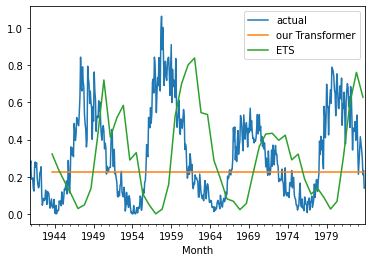

In [26]:
val_sp_scaled.plot(label='actual')
pred_series.plot(label='our Transformer')
pred_series_ets.plot(label='ETS')
plt.legend();
print("RNN MAPE:", mape(pred_series, val_sp_scaled))
print("ETS MAPE:", mape(pred_series_ets, val_sp_scaled))